In [8]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from copy import deepcopy
from tqdm import tqdm

# define the data, 2-D sphere

(-1.5, 1.5)

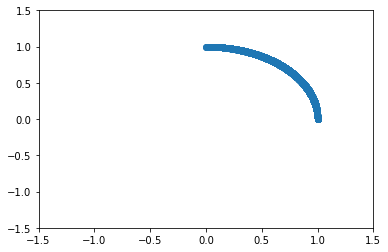

In [16]:
data_dim = 2
train_data = torch.rand(2500,data_dim)
train_data /= torch.norm(train_data,dim=1).reshape(-1,1)


    
plt.scatter(train_data[:,0],train_data[:,1])
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

# define the time-dependent MLP-UNet

In [10]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class MyBlock(nn.Module):
    def __init__(self, shape, out_c, block_layer):
        super(MyBlock, self).__init__()
        self.w1 = nn.Linear(shape, out_c)
        self.block_layer = block_layer
        for nl in range(2,self.block_layer+1):
            setattr(self,"w_"+str(nl),nn.Linear(out_c,out_c))
        self.activation = lambda x: x * torch.sigmoid(x)


    def forward(self, x):
        out = self.w1(x)
        out = self.activation(out)
        for nl in range(2,self.block_layer+1):
            out = self.activation(getattr(self,"w_"+str(nl))(out))
        return out

class UNet_MLP(nn.Module):
    def __init__(self, input_dim, cond_dim, cond_emb_dim = 32, time_emb_dim=32, scale = 9, block_layer = 1):
        super(UNet_MLP, self).__init__()

        # Sinusoidal embedding
        self.act = lambda x: x * torch.sigmoid(x)
        # Sinusoidal embedding
        self.time_embed = nn.Sequential(GaussianFourierProjection(embed_dim=time_emb_dim),
         nn.Linear(time_emb_dim, time_emb_dim))
        
        self.input_dim = input_dim

        self.cond_embed = MyBlock(cond_dim,cond_emb_dim,block_layer)
        self.cond_embed_dim = cond_emb_dim
        
        # First half
        first_num = 2 ** scale
        self.x_embed = MyBlock(input_dim,first_num,block_layer)
        
        self.te1 = self._make_emb(time_emb_dim, first_num)
        self.ce1 = self._make_emb(cond_emb_dim, first_num)
        self.b1 = MyBlock(first_num, first_num,block_layer)

        

        second_num = first_num // 2
        self.down1 = MyBlock(first_num,second_num,block_layer)
        
        self.te2 = self._make_emb(time_emb_dim, second_num)
        self.ce2 = self._make_emb(cond_emb_dim , second_num)
        self.b2 = MyBlock(second_num,second_num,block_layer)
    
        
        third_num = second_num // 2
        self.down2 = MyBlock(second_num,third_num,block_layer)


        # Bottleneck
        self.te_mid = self._make_emb(time_emb_dim, third_num)
        self.ce_mid = self._make_emb(cond_emb_dim, third_num)
        self.b_mid = MyBlock(third_num, third_num,block_layer)
    

        # Second half
        self.up1 = MyBlock(third_num, second_num,block_layer)

        self.te3 = self._make_emb(time_emb_dim, first_num)
        self.ce3 = self._make_emb(cond_emb_dim, first_num)
        self.b3 = MyBlock(first_num, second_num,block_layer)

        self.up2 = MyBlock(second_num, first_num,block_layer)
        self.te4 = self._make_emb(time_emb_dim, first_num * 2)
        self.ce4 = self._make_emb(cond_emb_dim, first_num * 2)
        self.b4 = MyBlock(first_num * 2, first_num,block_layer)
        

        self.final = nn.Linear(first_num, input_dim)

    def forward(self, x0, ti, xc_inp = None):
        t = self.act(self.time_embed(ti))
        x = self.x_embed(x0)
        if xc_inp is None:
            xc = torch.zeros(x.shape[0],self.cond_embed_dim).to(x.device) - 1
        else:
            xc = self.cond_embed(xc_inp)
        
        out1 = self.b1(x + self.te1(t) + self.ce1(xc))   # (N, first_num) 
        out2 = self.b2(self.down1(out1) + self.te2(t) + self.ce2(xc))    # (N, second_num)
        out_mid = self.b_mid(self.down2(out2)+ self.te_mid(t) + self.ce_mid(xc))   # (N, third_num)
        
        out3 = torch.cat((out2, self.up1(out_mid)), dim=1)  # (N, first_num)
        out4 = self.b3(out3+ self.te3(t)+ self.ce3(xc))    # (N, second)

        out5 = torch.cat((out1, self.up2(out4)), dim=1)  # (N, first_num * 2)
        out6 = self.b4(out5+ self.te4(t)+ self.ce4(xc))    # (N, first_num)

        out = self.final(out6) # (N, out)

        return out

    def _make_emb(self, dim_in, dim_out):
        return nn.Linear(dim_in, dim_out)

# define the denoising loss

In [11]:
def bounded_denoising_loss(net, batch_data, eps = 1e-5):
    batch_len = len(batch_data)
    noisy_levels = (torch.rand(batch_len).cuda()) * (1 - 2 * eps) + eps # 0.001 ~ 1
    noise = torch.randn(batch_data.shape).cuda()
    noisy_data = batch_data * torch.sqrt(1 - noisy_levels.reshape(-1,1)) + torch.sqrt(noisy_levels.reshape(-1,1)) * noise
    noisy_data /= torch.norm(noisy_data,dim=1).reshape(-1,1) # the bounded set is the unit sphere
    predicted_noise = net(noisy_data, noisy_levels)
    loss  = torch.mean(torch.sum((predicted_noise - noise)**2, dim = 1)) 
    return loss

def index_iterator(data_len, batch_size, shuffle=True):
    if shuffle:
        indices = np.random.permutation(data_len)
    else:
        indices = np.arange(data_len)
    for i in range(0, data_len, batch_size):
        yield indices[i:i+batch_size]

# Generation function

In [17]:
def ddim_sampling(model, sample_size = 100, total_steps = 1000, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = 1 - eps
    interp = now_coeff / total_steps
    sample_points = torch.randn(sample_size,2).cuda()

    for _ in range(total_steps-1):
        nl = eta * np.sqrt(now_coeff - interp) 
        with torch.no_grad():
            direction = model(sample_points, torch.zeros(sample_size).cuda() + now_coeff)
        sample_points = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction + nl * torch.randn(sample_size,2).cuda()
        now_coeff -= interp

    return sample_points.cpu().numpy()

def bounded_ddim_sampling(model, sample_size = 100, total_steps = 1000, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = 1 - eps
    interp = now_coeff / total_steps
    sample_points = torch.randn(sample_size,2).cuda()

    for _ in range(total_steps-1):
        nl = eta * np.sqrt(now_coeff - interp) 
        with torch.no_grad():
            direction = model(sample_points, torch.zeros(sample_size).cuda() + now_coeff)
        sample_points = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction + nl * torch.randn(sample_size,2).cuda()
        sample_points /= torch.norm(sample_points,dim=1).reshape(-1,1)
        now_coeff -= interp

    return sample_points.cpu().numpy()

# training with EMA

  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▍         | 49/1000 [00:23<07:32,  2.10it/s, avg_loss=0.825, last_loss=0.55] 

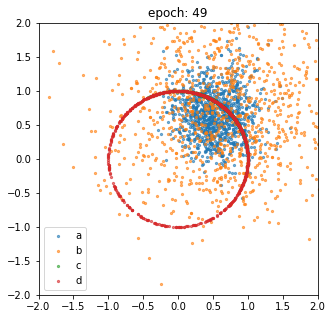

  5%|▌         | 50/1000 [00:28<30:56,  1.95s/it, avg_loss=0.825, last_loss=0.55]

saved at epoch 49


 10%|▉         | 99/1000 [00:52<07:01,  2.14it/s, avg_loss=0.852, last_loss=1.37] 

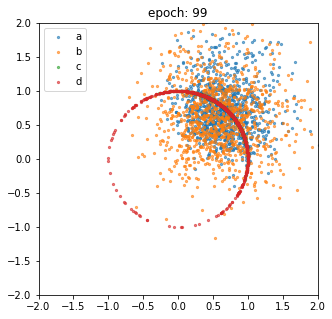

 10%|█         | 100/1000 [00:57<29:14,  1.95s/it, avg_loss=0.852, last_loss=1.37]

saved at epoch 99


 15%|█▍        | 149/1000 [01:20<06:37,  2.14it/s, avg_loss=0.788, last_loss=0.565]

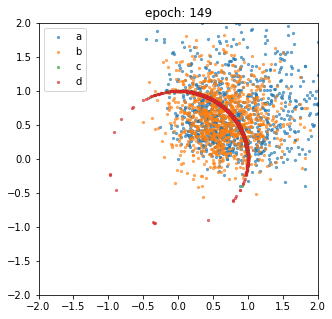

 15%|█▌        | 150/1000 [01:25<27:32,  1.94s/it, avg_loss=0.788, last_loss=0.565]

saved at epoch 149


 20%|█▉        | 199/1000 [01:49<06:17,  2.12it/s, avg_loss=0.807, last_loss=0.419] 

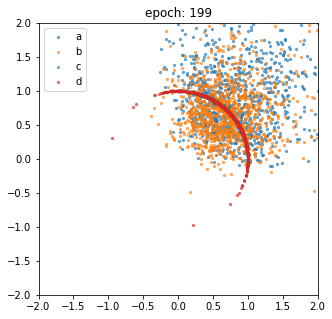

 20%|██        | 200/1000 [01:54<25:50,  1.94s/it, avg_loss=0.807, last_loss=0.419]

saved at epoch 199


 25%|██▍       | 249/1000 [02:17<05:54,  2.12it/s, avg_loss=0.817, last_loss=0.438]

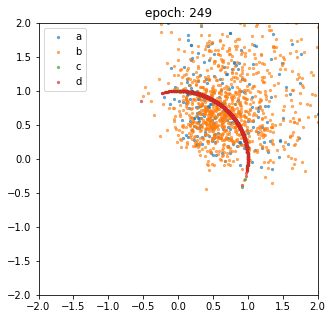

 25%|██▌       | 250/1000 [02:22<24:15,  1.94s/it, avg_loss=0.817, last_loss=0.438]

saved at epoch 249


 30%|██▉       | 299/1000 [02:46<05:30,  2.12it/s, avg_loss=0.787, last_loss=1.8]   

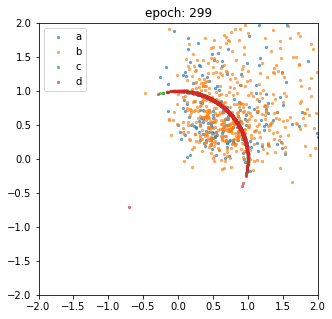

 30%|███       | 300/1000 [02:50<22:42,  1.95s/it, avg_loss=0.787, last_loss=1.8]

saved at epoch 299


 35%|███▍      | 349/1000 [03:14<05:03,  2.15it/s, avg_loss=0.773, last_loss=0.208]

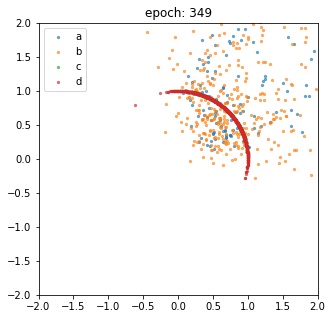

 35%|███▌      | 350/1000 [03:19<20:59,  1.94s/it, avg_loss=0.773, last_loss=0.208]

saved at epoch 349


 40%|███▉      | 399/1000 [03:43<04:42,  2.13it/s, avg_loss=0.819, last_loss=1.69] 

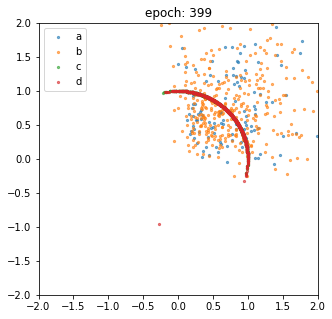

 40%|████      | 400/1000 [03:47<19:28,  1.95s/it, avg_loss=0.819, last_loss=1.69]

saved at epoch 399


 45%|████▍     | 449/1000 [04:11<04:19,  2.13it/s, avg_loss=0.808, last_loss=1.13] 

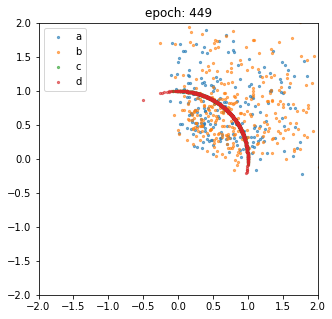

 45%|████▌     | 450/1000 [04:16<17:47,  1.94s/it, avg_loss=0.808, last_loss=1.13]

saved at epoch 449


 50%|████▉     | 499/1000 [04:40<03:58,  2.10it/s, avg_loss=0.776, last_loss=0.58] 

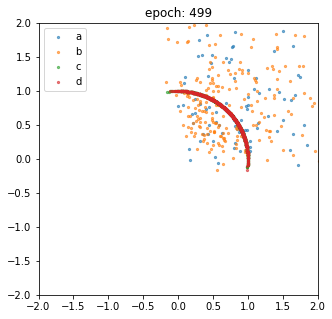

 50%|█████     | 500/1000 [04:44<16:13,  1.95s/it, avg_loss=0.776, last_loss=0.58]

saved at epoch 499


 55%|█████▍    | 549/1000 [05:08<03:31,  2.13it/s, avg_loss=0.805, last_loss=0.207]

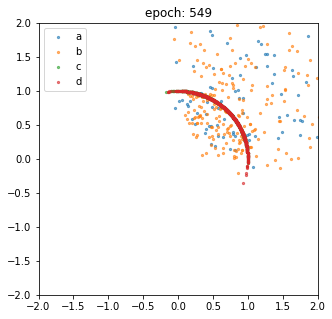

 55%|█████▌    | 550/1000 [05:13<14:35,  1.95s/it, avg_loss=0.805, last_loss=0.207]

saved at epoch 549


 55%|█████▌    | 551/1000 [05:14<04:15,  1.75it/s, avg_loss=0.819, last_loss=0.423]


KeyboardInterrupt: 

In [18]:
EPOCH = 1000

lr=1e-4
batch_size = 32

model = UNet_MLP(data_dim, 1, 1).cuda()
EMA_model = UNet_MLP(data_dim, 1, 1).cuda()
EMA_model.load_state_dict(deepcopy(model.state_dict()))
train_data = train_data.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

progress = tqdm(range(EPOCH))
for epoch in progress:
    avg_loss = 0
    totals = 0
    for batch_idx in index_iterator(len(train_data), batch_size):
        optimizer.zero_grad()
        loss  = bounded_denoising_loss(model, train_data[batch_idx])
        loss.backward()
        optimizer.step()
        totals += len(batch_idx)
        avg_loss += loss.item() * len(batch_idx)
    
    for p, ema_p in zip(model.parameters(), EMA_model.parameters()):
        ema_p.data.mul_(0.99).add_(0.01, p.data)

    progress.set_postfix({"avg_loss":avg_loss/totals,"last_loss":loss.item()})

    if (epoch + 1) % 50 == 0:
        ema_sample_points = ddim_sampling(EMA_model, 1000, eta = 0.3)
        sample_points = ddim_sampling(model, 1000, eta = 0.3)
        ema_sample_points_eta0 = bounded_ddim_sampling(EMA_model, 1000, eta = 0.3)
        sample_points_eta0 = bounded_ddim_sampling(model, 1000, eta = 0.3)
        plt.figure(figsize=(5,5))
        plt.scatter(sample_points[:,0], sample_points[:,1], s=5, alpha=0.6, label="a")
        plt.scatter(ema_sample_points[:,0], ema_sample_points[:,1], s=5,alpha=0.6, label="b")
        plt.scatter(sample_points_eta0[:,0], sample_points_eta0[:,1], s=5,alpha=0.6, label="c")
        plt.scatter(ema_sample_points_eta0[:,0], ema_sample_points_eta0[:,1], s=5,alpha=0.6, label="d")
        plt.xlim(-2,2)
        plt.ylim(-2,2)
        plt.legend()
        plt.title("epoch: {}".format(epoch))
        plt.savefig("temp_results/ddim_{}_mg.png".format(epoch))
        plt.show()
        torch.save(model.state_dict(), "temp_results/ddim_mg.pth".format(epoch))
        torch.save(EMA_model.state_dict(), "temp_results/ddim_ema_mg.pth".format(epoch))
        print("saved at epoch {}".format(epoch))



In [ ]:
model = UNet_MLP(data_dim, 1, 1).cuda()
model.load_state_dict(torch.load("temp_results/ddim_ema_mg.pth"))

# ema_sample_points1 = ddim_sampling(EMA_model, 1000, eta = 0.2)
ema_sample_points2 = ddim_sampling(model, 1000, total_steps=1000, eta = 0.1)
# ema_sample_points3 = ddim_sampling(EMA_model, 1000, eta = 0.4)
# ema_sample_points4 = ddim_sampling(EMA_model, 1000, eta = 0.5)

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.scatter(ema_sample_points2[:,0], ema_sample_points2[:,1], s=5, alpha=0.6, label="1")
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.legend()
plt.subplot(1,4,2)
plt.scatter(ema_sample_points2[:,0], ema_sample_points2[:,1], s=5,alpha=0.6, label="2")
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.legend()
plt.subplot(1,4,3)
plt.scatter(ema_sample_points2[:,0], ema_sample_points2[:,1], s=5,alpha=0.6, label="3")
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.legend()
plt.subplot(1,4,4)
plt.scatter(ema_sample_points2[:,0], ema_sample_points2[:,1], s=5,alpha=0.6, label="4")
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.legend()
plt.show()